In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time
import pickle

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.ESPRIT_numpy import *
from HN_decomposition.Subspace.PQMF import *

def RMS(x):
        return np.std(x)

figsize = (9/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

## ESTER Criterion

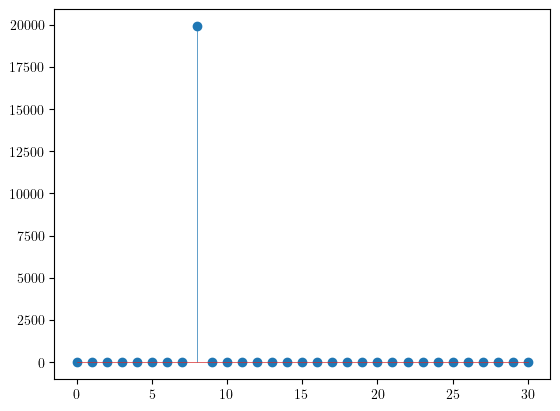

In [3]:
amps_nus = [[1, .1], [1, .2], [1, .4], [.9, .04]]

amp_noise = .1
length_smp = 512

x = np.zeros(length_smp, dtype= np.complex128)

for amp_nu in amps_nus:
    amp = amp_nu[0]
    nu = amp_nu[1]
    x += amp*np.sin(2*np.pi*nu*np.arange(length_smp))

x += amp_noise*np.random.randn(length_smp)


_, J_list = ESTER(
    x=x,
    start_idx = 15,
    window_length = 256,
    max_poles = 30,
    factor = 10
)

plt.stem(J_list)
plt.show()

## Loading the audio file

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_1_P_2.mat
dict_keys(['__header__', '__version__', '__globals__', 'FRF', 'acc_t', 'fen_acc', 'fen_mar', 'freq', 'fs', 'mar_t', 'None', 'signal_accelero_fen', 'signal_marteau_fen', 'time', '__function_workspace__'])
sample rate : 51200 Hz


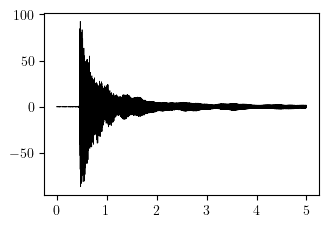

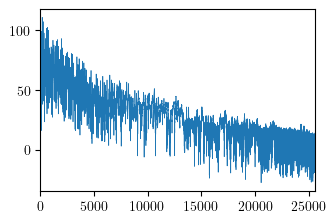

In [4]:
start_sec = .82
length_sec = 4

start_sec = 0
length_sec = 5

fileName = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM',
    'Medium_1', 'Corde_Acier', 'C_1_P_2.mat')
print(fileName)
data = scipy.io.loadmat(fileName)
print(data.keys())

sr_hz_old =  data['fs'][0,0]
x = data['acc_t'][int(sr_hz_old*start_sec):int(sr_hz_old*(start_sec+length_sec)),0].T
t = np.arange(len(x))/sr_hz_old

print(f'sample rate : {sr_hz_old} Hz')

plt.figure(figsize = figsize)
plt.plot(t,x,'k', linewidth = .5)
plt.show()

plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz_old), dB20(np.fft.rfft(x)))
#plt.semilogx()
plt.xlim(0, sr_hz_old/2)
plt.show()

## Resampling

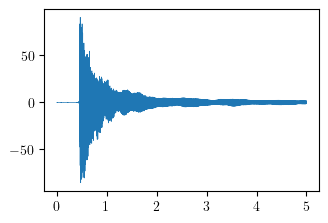

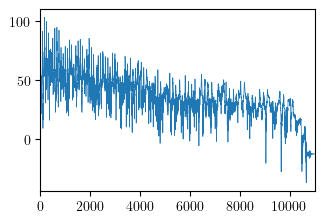

In [5]:
sr_hz = 22050
x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
t = np.arange(len(x))/sr_hz
plt.figure(figsize = figsize)
plt.plot(t,x)
plt.show()
plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz), dB20(np.fft.rfft(x)))
plt.xlim(0, sr_hz/2)
plt.show()

In [6]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Partials_Tracking", "Figures")

In [7]:
def compute_spectralCentroid(
    x_fft:npt.ArrayLike,
    f:npt.ArrayLike
    ):
    """
    Computes the spectral centroid of the signal from its fft based on
    [1, p.135].
    
    Parameters :
    ------------
    `x_fft` : array-like
        FFT of the signal.
    `f` : array-like
        Frequencies.
    
    Returns :
    ---------
    `spectral_centroid` : float
        Spectral centroid of the signal.
    
    References :
    ------------
    [1] Klapuri, Anssi, and Manuel Davy, eds. Signal Processing Methods for
    Music Transcription. New York: Springer, 2006.
    """
    x_fft_norm = np.abs(x_fft)
    x_fft_norm /= np.sum(x_fft_norm)
    spectral_centroid:float = np.sum(x_fft_norm*f)/np.sum(x_fft_norm)
    return spectral_centroid

def compute_spectralBandwidth(
    x_fft:npt.ArrayLike,f:npt.ArrayLike,
    order:float = 2, centroid:float = None
    ):
    """
    Computes the spectral bandwidth of the signal from its fft based on
    [1, p.135].
    
    Parameters :
    ------------
    `x_fft` : array-like
        FFT of the signal.
    `f` : array-like
        Frequencies.
    `order` : float
        Order of the distance function used.
    `centroid` : float
        Pre-computed centroid. If `None`, the centroid will be computed inside
        this function.
    
    Returns :
    ---------
    `spectral_bandwidth` : float
        Spectral bandwidth of the signal.
    
    References :
    ------------
    [1] Klapuri, Anssi, and Manuel Davy, eds. Signal Processing Methods for
    Music Transcription. New York: Springer, 2006.
    """
    if centroid == None:
        centroid = compute_spectralCentroid(x_fft, f)
    
    x_fft_norm = np.abs(x_fft)
    x_fft_norm /= np.sum(x_fft_norm)

    spectral_bandwidth:float = np.power(
        np.sum(x_fft_norm*np.power(np.abs(f-centroid), order)),
        1/order
    )
    return spectral_bandwidth

def compute_RMS(x:npt.ArrayLike):
    """
    Computes the RMS level of a signal

    Parameters :
    ------------
    `x` : array-like
        input signal.
    
    Returns :
    ---------
    `RMS` : float
        RMS (root mean square) level of the signal.
    """
    RMS:float = np.sqrt(np.mean(np.square(x)))
    return RMS

def compute_ZCR(x:npt.ArrayLike):
    """
    Computes the zero-crossings rate of the input signal.
    
    Parameters :
    ------------
    `x` : array-like
        Input signal.
    
    Returns :
    ---------
    `ZCR` : float
        Zero-crossings rate of the signal.
    """
    crossings = 0
    for i in range(len(x)-1):
        if x[i+1]*x[i]<0:
            crossings+=1
    return crossings/len(x)

def compute_features(
    x:npt.ArrayLike,
    sr:float,
    features_list:tuple,
    **kwargs):
    """
    Computes efficiently multiple audio feautures

    Parameters :
    ------------
    `x` : array-like
        Input signal.
    `sr` : float
        Sample rate.
    `features_list` : tuple of strings
        tuple or list containing the keys of the features to be computed.
    
    Returns :
    ---------
    `features_dict` : dict
        Dictionnary containing the requested features values.
    
    
    Supported feature keys :
    ------------------------
    `centroid` : spectral centroid.
    `bandwidth` : spectral bandwidth.
    `ZCR` : Zero-crossings rate.
    `RMS` : RMS level.

    Keyword arguments :
    -------------------
    `bandwidth_order` : float
        Order of the distance function used to compute the spectral bandwidth.
    """
    
    features_dict = {}

    if 'centroid' in features_list or 'bandwidth' in features_list:
        x_fft = np.fft.rfft(x)
        f = np.fft.rfftfreq(len(x), 1/sr)

    centroid = None
    if 'centroid' in features_list:
        centroid = compute_spectralCentroid(x_fft, f)
        features_dict['centroid'] = centroid
    
    if 'bandwidth' in features_list:
        if 'bandwidth_order' in kwargs:
            bandwidth_order = kwargs['bandwidth_order']
        else:
            bandwidth_order = 2
        
        bandwidth = compute_spectralBandwidth(
            x_fft = x_fft, 
            f = f,
            order = bandwidth_order,
            centroid = centroid)
        features_dict['bandwidth'] = bandwidth
    
    if 'ZCR' in features_list:
        ZCR = compute_ZCR(x)
        features_dict['ZCR'] = ZCR
    
    if 'RMS' in features_list:
        RMS = compute_RMS(x)
        features_dict['RMS'] = RMS
    return features_dict


c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


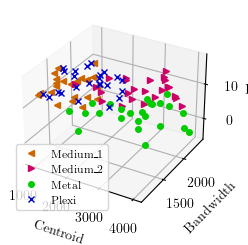

In [8]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 64

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
#list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384


ax = plt.figure(figsize = figsize).add_subplot(projection = '3d')
for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    ZCR_list = []
    for corde_str in list_cordes:
        for plectre_str in list_plectres:
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            
            start_idx = np.argmax(np.abs(sig.hilbert(x)))
            x = x[start_idx:start_idx+int(3*sr_hz_old)]
            x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            #xHarmo, xNoise = multiband_HN(
            #    np.real(x),
            #    tracking_method = 'FAPI',
            #    num_bands = num_bands,
            #    ester_factor=ester_factor,
            #    window_length=window_length,
            #    hop_length=hop_length,
            #    FAPI_beta = .95)
            
            x_fft = np.fft.rfft(x)
            f = np.fft.rfftfreq(len(x), 1/sr_hz)

            spectral_centroid = compute_spectralCentroid(
                x_fft, f)
            spectral_bandwidth = compute_spectralBandwidth(
                x_fft, f, order = 2, centroid = spectral_centroid)
            RMS = compute_RMS(x)
            ZCR = compute_ZCR(x)
            
            centroid_list.append(spectral_centroid)
            bandwidth_list.append(spectral_bandwidth)
            RMS_list.append(dB20(RMS))
            ZCR_list.append(ZCR)
    ax.plot(centroid_list, bandwidth_list, zs = RMS_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 4)
ax.set_xlabel('Centroid')
ax.set_ylabel('Bandwidth')
ax.set_zlabel('RMS')
#ax.set_title('Données mesurées')
plt.legend(prop = {'size' : 8})
plt.tight_layout()
plt.show()

            

C:\Users\pelad\AppData\Local\Temp\ipykernel_10656\2510722002.py:22: FutureWarning: Pass y=[ 0.00000000e+00  3.89558205e-03 -9.83511677e-05 ... -1.64309058e-02
 -1.06184851e-02 -4.62161212e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  centroid_libr = librosa.feature.spectral_centroid(x, sr = sr_hz, n_fft = len(x))


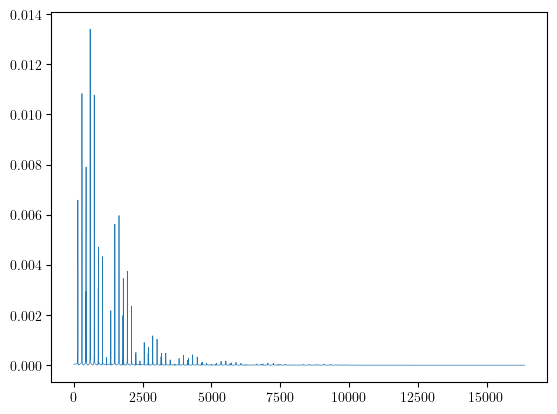

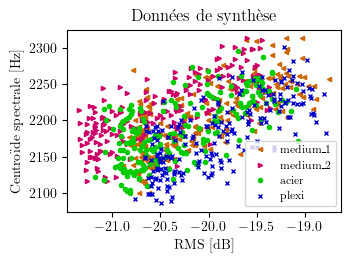

In [9]:
folder_mesures = os.path.join(
    '..',
    '..',
    'Dataset_1')

list_tables = ['medium_1', 'medium_2', 'acier', 'plexi']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384

file_name = os.path.join(
    folder_mesures,
    'acier',
    'Wav',
    '0' + '.wav')
sr_hz, x = scipy.io.wavfile.read(file_name)
x_fft = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x), 1/sr_hz)

centroid_come = compute_spectralCentroid(x_fft, sr_hz)
centroid_libr = librosa.feature.spectral_centroid(x, sr = sr_hz, n_fft = len(x))
plt.plot(f, np.abs(x_fft/np.sum(np.abs(x_fft))))
plt.show()

plt.figure(figsize = figsize)
for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    for sample_idx in range(200):
        file_name = os.path.join(
            folder_mesures,
            table_str,
            'Wav',
            str(sample_idx) + '.wav'
        )
        sr_hz_old, x = scipy.io.wavfile.read(file_name)
        
        #x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
        sr_hz = sr_hz_old
        x = x[int(sr_hz*0):]
        t = np.arange(len(x))/sr_hz

        x_fft = np.fft.rfft(x)
        f = np.fft.rfftfreq(len(x), 1/sr_hz)

        spectral_centroid = compute_spectralCentroid(
            x_fft, f)
        spectral_bandwidth = compute_spectralBandwidth(
            x_fft, f, order = 2, centroid = spectral_centroid)
        RMS = compute_RMS(x)

        centroid_list.append(spectral_centroid)
        bandwidth_list.append(spectral_bandwidth)
        RMS_list.append(dB20(RMS))
    plt.plot(RMS_list, centroid_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 3)
    plt.ylabel('Centroïde spectrale [Hz]')
    plt.xlabel('RMS [dB]')
plt.title("Données de synthèse")
plt.legend(prop = {'size' : 8})
plt.show()

            

## Testing the H+N Decomposition on synthesis samples

In [22]:
folder_mesures = os.path.join(
    '..',
    '..',
    'Dataset_1')

list_tables = ['medium_1', 'medium_2', 'acier', 'plexi']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']

file_name = os.path.join(
    folder_mesures,
    'medium_2',
    'Wav',
    '199' + '.wav')
sr_hz, x = scipy.io.wavfile.read(file_name)
print(sr_hz)
x_fft = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x), 1/sr_hz)

xHarmo, xNoise = multiband_HN(x)

display(Audio(data = x, rate = sr_hz))
display(Audio(data = np.real(xHarmo), rate = sr_hz))
display(Audio(data = np.real(xNoise), rate = sr_hz))

32768


## Computing the harmonic+noise SNR

In [10]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 64

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384

SNR_list = []
for i, table_str in enumerate(list_tables):
    for corde_str in list_cordes:
        for plectre_str in list_plectres:
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            print(file_name)
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            xHarmo, xNoise = multiband_HN(
                np.real(x),
                tracking_method = 'FAPI',
                num_bands = num_bands,
                ester_factor=ester_factor,
                window_length=window_length,
                hop_length=hop_length,
                FAPI_beta = .95)
            
            SNR_list.append(compute_RMS(xHarmo)/compute_RMS(xNoise))
            

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_1.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_3.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_4.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_1.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_3.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_4.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_1.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_3.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_4.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Plexi\Corde_Acier\C_3_P_1.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Plexi\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\P

In [11]:
SRN_list = np.array(SNR_list)

print(dB20(np.mean(SNR_list)))
print(dB20(np.std(SNR_list)))

13.842567752197759
5.979679175148766
